In [ ]:
!pip install opencv-python numpy pytesseract gradio Pillow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.2/57.2 MB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.2/320.2 kB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.2/11.2 MB 97.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.2/73.2 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.8/63.8 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.2/168.2 kB 11.8 MB/s eta 0:00:00
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 3.0.2
    Uninstalling MarkupSafe-3.0.2:
      Successfully uninstalled MarkupSafe-3.0.2


In [ ]:
!sudo apt install tesseract-ocr tesseract-ocr-amh poppler-utils

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  poppler-utils tesseract-ocr tesseract-ocr-amh tesseract-ocr-eng
  tesseract-ocr-osd
0 upgraded, 5 newly installed, 0 to remove and 49 not upgraded.
Need to get 6,858 kB of archives.
After this operation, 21.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 poppler-utils amd64 22.02.0-2ubuntu0.5 [186 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:4 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr amd64 4.1.1-2.1build1 [236 kB]
Get:5 http://archive.ubuntu.com/ubuntu jammy/universe amd64 

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://26a1035192e416a30d.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


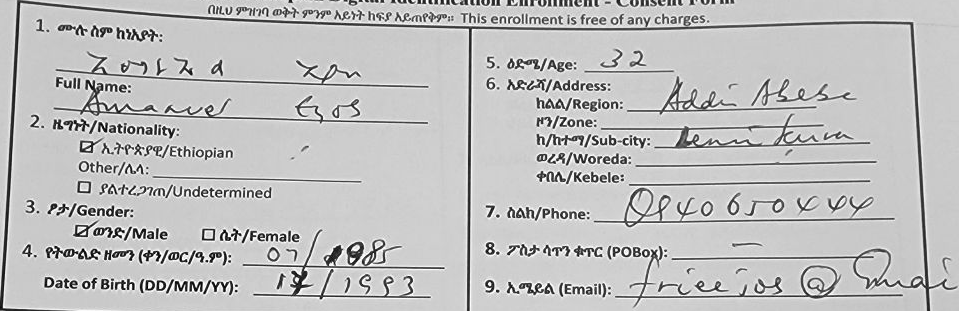

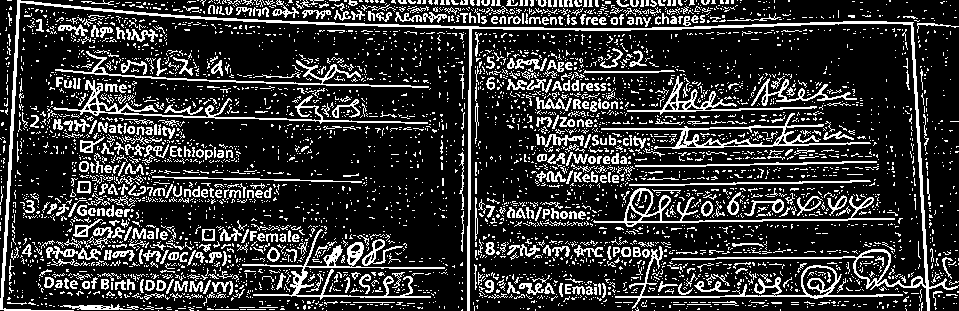

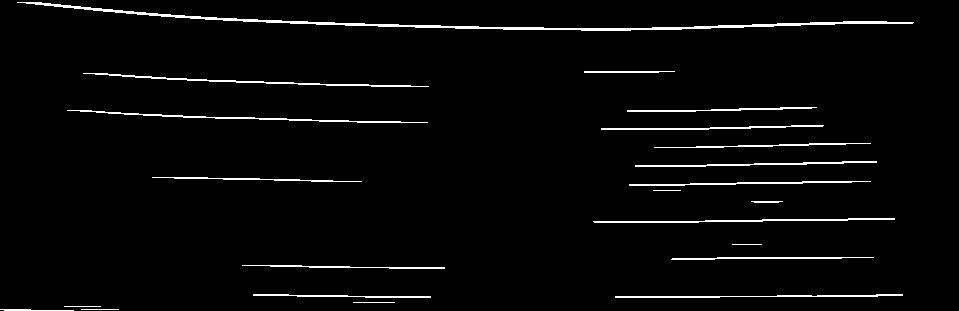

Contour Length: 74.0
Contour Length: 146.82842707633972
Valid Contour Length: 146.82842707633972
Contour Length: 72.0
Contour Length: 82.0
Contour Length: 578.4852812290192
Valid Contour Length: 578.4852812290192
Contour Length: 357.65685415267944
Valid Contour Length: 357.65685415267944
Contour Length: 407.0710676908493
Valid Contour Length: 407.0710676908493
Contour Length: 405.65685415267944
Valid Contour Length: 405.65685415267944
Contour Length: 58.0
Contour Length: 605.899494767189
Valid Contour Length: 605.899494767189
Contour Length: 62.82842707633972
Contour Length: 54.0
Contour Length: 485.899494767189
Valid Contour Length: 485.899494767189
Contour Length: 421.3137083053589
Valid Contour Length: 421.3137083053589
Contour Length: 487.3137083053589
Valid Contour Length: 487.3137083053589
Contour Length: 435.3137083053589
Valid Contour Length: 435.3137083053589
Contour Length: 447.899494767189
Valid Contour Length: 447.899494767189
Contour Length: 729.9411249160767
Valid Contour

In [ ]:
import cv2
import numpy as np
import pytesseract
import gradio as gr
from PIL import Image
import io
import os
from google.colab.patches import cv2_imshow

class FormOCR:
    def __init__(self):
        # Constants for the first box (personal information section)
        self.FIRST_BOX_START = "1. ሙሉ ስም ስሙትና:"  # The text that starts the first box
        self.MIN_LINE_LENGTH = 70
        self.MAX_LINE_GAP = 10
        self.FIELD_HEIGHT = 35  # Height of the box around detected lines
        self.LINE_BOTTOM_RATIO = 0.7  # Position of line from top of box (0.7 means 70% from top)

    def preprocess_image(self, image):
        """Preprocess the image for better feature detection."""
        # Convert to grayscale
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # Enhance contrast
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        gray = clahe.apply(gray)

        # Adaptive thresholding
        thresh = cv2.adaptiveThreshold(
            gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2
        )

        return gray, thresh

    def detect_main_box(self, image):
        """Detect the main box containing personal information using contour detection."""
        # Get image dimensions
        height, width = image.shape[:2]

        # Focus on the top portion of the image where the main box typically is
        top_portion = int(height * 0.4)
        roi = image[:top_portion, :]

        # Convert to grayscale and apply adaptive thresholding
        if len(roi.shape) == 3:
            gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
        else:
            gray = roi.copy()

        thresh = cv2.adaptiveThreshold(
            gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2
        )

        # Find contours
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Initialize variables for best box
        best_box = None
        max_area = 0
        target_ratio = 3.5  # Expected width/height ratio for the main box

        for contour in contours:
            # Approximate the contour to a polygon
            approx = cv2.approxPolyDP(contour, 0.02 * cv2.arcLength(contour, True), True)

            # Check if it's a rectangle (4 corners)
            if len(approx) == 4:
                x, y, w, h = cv2.boundingRect(approx)
                area = w * h
                ratio = w / h if h != 0 else 0

                if (area > max_area and  # Largest area
                    y < top_portion * 0.8 and  # Near the top
                    ratio > 2 and ratio < 5 and  # Reasonable aspect ratio
                    w > width * 0.5):  # At least half the image width

                    max_area = area
                    best_box = approx

        if best_box is not None:
            return best_box.reshape((-1, 1, 2))

        return None


    def detect_field_regions(self, image, box):
        # Detect horizontal lines within the main box and create regions around them.
        if box is None:
            return []

        # Get box boundaries
        x, y, w, h = cv2.boundingRect(box)

        # Extract only the main box region
        roi = image[y:y+h, x:x+w]


        # Convert to grayscale if needed
        if len(roi.shape) == 3:
            roi_gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
        else:
            roi_gray = roi

        cv2_imshow(roi_gray)


        # Apply thresholding to isolate lines
        thresh = cv2.adaptiveThreshold(
            roi_gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2
        )

        # Display the thresholded image
        cv2_imshow(thresh)

        # Use morphological operations to enhance horizontal lines
        horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (25, 1))
        horizontal = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, horizontal_kernel)

        cv2_imshow(horizontal)

        # cv2.waitKey(0)
        # cv2.destroyAllWindows()

        # Find contours of horizontal lines
        contours, _ = cv2.findContours(horizontal, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Filter and sort contours
        valid_contours = []
        for contour in contours:
            contour_length = cv2.arcLength(contour, True)
            print("Contour Length:", contour_length)


            x_line, y_line, w_line, h_line = cv2.boundingRect(contour)

            # Filter based on line width and position
            if w_line > self.MIN_LINE_LENGTH and w_line < w/2 and h_line < 20: #and (abs(y - y_line) > 20 or abs(y + h - y_line) > 20):
                valid_contours.append((y_line, contour))

                valid_contour_length = cv2.arcLength(contour, True)
                print("Valid Contour Length:", valid_contour_length)


        # Sort by vertical position
        valid_contours.sort(key=lambda x: x[0])

        # Create regions around each line
        regions = []
        for i, (y_line, contour) in enumerate(valid_contours):
            x_line, y_line, w_line, h_line = cv2.boundingRect(contour)

            # Create a box around the line
            box_height = self.FIELD_HEIGHT

            # Calculate y position so the line is towards the bottom of the box
            y_start = max(0, y_line - int(box_height * self.LINE_BOTTOM_RATIO))

            # Extend width to the borders of the main box
            # Add small padding from the edges
            # padding = 10
            # x_start = padding
            # x_end = w - padding

            # # Add region with global coordinates
            # regions.append({
            #     'name': f'Field_{i+1}',
            #     'coords': (
            #         x + x_start,  # Global x coordinate
            #         y + y_start,  # Global y coordinate
            #         x + x_end,    # Global x2 coordinate (extended to border)
            #         y + y_start + box_height  # Global y2 coordinate
            #     )
            # })

            # Add region with global coordinates
            regions.append({
                'name': f'Field_{i+1}',
                'coords': (
                    x + x_line,  # Global x coordinate
                    y + y_start,  # Global y coordinate
                    x + x_line + w_line + 30,  # Global x2 coordinate
                    y + y_start + box_height  # Global y2 coordinate
                )
            })

        return regions

    def ensure_vertical_orientation(self, image):
        """
        Check image orientation and rotate if not vertical.

        Args:
            image (numpy.ndarray): Input image in BGR color space

        Returns:
            numpy.ndarray: Vertically oriented image
        """
        # Calculate image height and width
        height, width = image.shape[:2]

        # Compare height and width to determine orientation
        if width > height:
            # Image is horizontal, rotate 90 degrees
            rotated_image = cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE)
            return rotated_image

        return image

    def process_form(self, input_image):
        """Process the form and extract all fields."""
        if isinstance(input_image, str):
            image = cv2.imread(input_image)
        else:
            image = cv2.cvtColor(np.array(input_image), cv2.COLOR_RGB2BGR)

        # Ensure image is vertical
        image = self.ensure_vertical_orientation(image)

        # Create visualization image
        viz_image = image.copy()

        # Detect main box
        main_box = self.detect_main_box(image)
        if main_box is None:
            return "Could not detect main form box", viz_image

        # Draw main box
        cv2.drawContours(viz_image, [main_box], -1, (0, 255, 0), 2)

        # Detect and process regions
        regions = self.detect_field_regions(image, main_box)

        results = {}
        region_images = []
        for region in regions:
            # Draw region on visualization image
            x1, y1, x2, y2 = region['coords']
            cv2.rectangle(viz_image, (x1, y1), (x2, y2), (255, 0, 0), 2)
            cv2.putText(viz_image, region['name'], (x1, y1-5),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)

            # Extract text from region
            text = self.extract_text(image, region)
            results[region['name']] = text

            # Extract and store region image
            region_img = image[y1:y2, x1:x2]
            region_images.append((region['name'], cv2.cvtColor(region_img, cv2.COLOR_BGR2RGB)))

        return results, cv2.cvtColor(viz_image, cv2.COLOR_BGR2RGB), region_images


    def extract_text(self, image, region):
        """Extract text from a specific region using Tesseract."""
        try:
            # Get region coordinates
            x1, y1, x2, y2 = region['coords']

            # Validate coordinates
            if x1 >= x2 or y1 >= y2:
                return "Invalid region coordinates"

            # Ensure coordinates are within image bounds
            height, width = image.shape[:2]
            x1 = max(0, min(x1, width - 1))
            x2 = max(0, min(x2, width))
            y1 = max(0, min(y1, height - 1))
            y2 = max(0, min(y2, height))

            # Check if region is too small
            if (x2 - x1) < 5 or (y2 - y1) < 5:
                return "Region too small"

            # Extract region of interest
            roi = image[y1:y2, x1:x2]

            # Verify ROI is not empty
            if roi is None or roi.size == 0:
                return "Empty region"

            # Convert to grayscale if needed
            if len(roi.shape) == 3:
                gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
            else:
                gray = roi.copy()

            # Apply thresholding
            thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

            # Verify thresh is not empty
            if thresh is None or thresh.size == 0:
                return "Thresholding failed"

            # OCR the image
            text = pytesseract.image_to_string(
                thresh,
                lang='eng+amh',
                config='--psm 7 --oem 3'
            )

            return text.strip() if text else "No text detected"

        except cv2.error as e:
            return f"OpenCV Error: {str(e)}"
        except Exception as e:
            return f"Error: {str(e)}"

def create_gradio_interface():
    """Create and launch the Gradio interface."""
    ocr = FormOCR()

    def process_image(image):
        results, viz_image, region_images = ocr.process_form(image)
        if isinstance(results, str):
            return viz_image, results, []

        formatted_results = "\n".join([f"{k}: {v}" for k, v in results.items()])
        return viz_image, formatted_results, [img for _, img in region_images]

    iface = gr.Interface(
        fn=process_image,
        inputs=gr.Image(type="pil"),
        outputs=[
            gr.Image(label="Detected Fields"),
            gr.Textbox(label="Extracted Text", lines=14),
            gr.Gallery(label="Individual Field Images")
        ],
        title="Fayda Form OCR System",
        description="Upload a Fayda-Ethiopian Digital ID form to extract handwritten information.",
        examples=[],
        theme="default"
    )

    return iface

if __name__ == "__main__":
    iface = create_gradio_interface()
    iface.launch(debug=True)

# 0000
